## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [39]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
print(cv2.__version__)

4.11.0


## Загружаем исходные данные

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [40]:
# посмотрим на размерность
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [41]:
# приводим размерность к удобному для обаботки виду
#train_img = np.resize(X_train[:, 1:], (X_train.shape[0], 28, 28)).astype('float64')
#test_img = np.resize(X_test, (X_test.shape[0], 28, 28)).astype('float64')

train_img = X_train.astype('float64')
test_img = X_test.astype('float64')
train_img.shape, test_img.shape

((60000, 28, 28), (10000, 28, 28))

## Визуализируем исходные данные

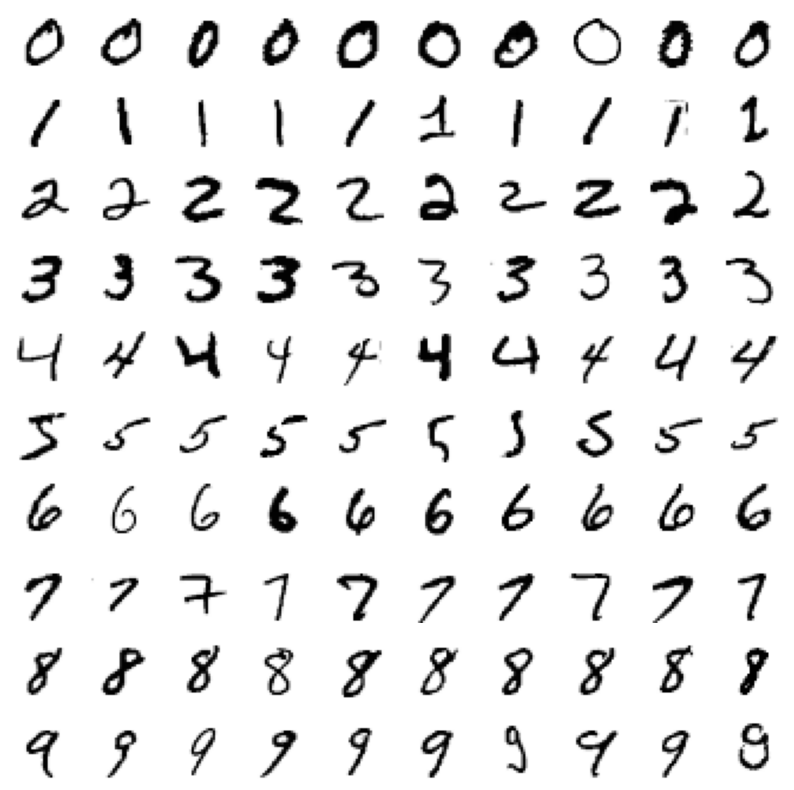

In [42]:
# найдем уникальные данные
unique_classes = np.unique(y_train)

# зададим размер картинки
fig, axes = plt.subplots(10,10, figsize=(10,10))

# нарисуем случайные изображения всех классов
for idx, digit in enumerate(unique_classes):
    selected_images = X_train[y_train==digit][0:10]

    for k in range(0,10):
        axes[digit,k].imshow(selected_images[k],
                             cmap='Greys',
                             vmin=0,
                             vmax=255)
        axes[digit,k].axis('off')

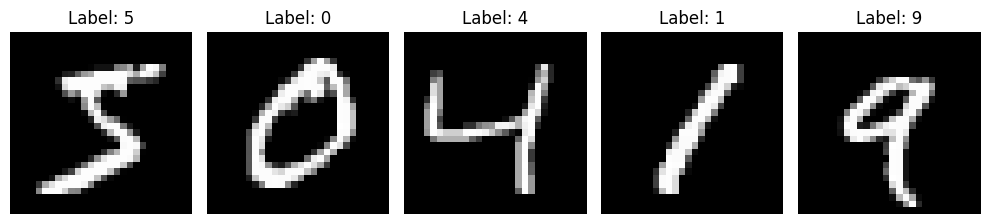

In [43]:
# или так
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i],
               cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

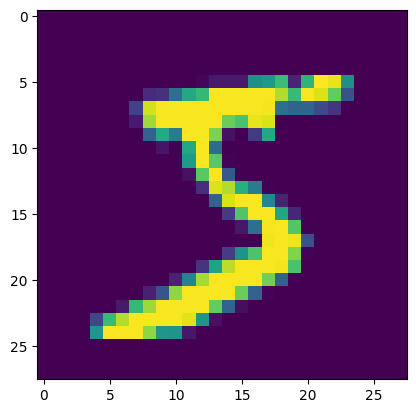

In [44]:
# или каждое конкретное изображение
plt.imshow(X_train[0])

In [51]:
# нормализуем
#X_train = X_train / 255.0
#X_test = X_test / 255.0

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [45]:
# зададим размер окна
ksize = 7

In [46]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

In [47]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

## Вычисляем угол и длину вектора градиента

In [48]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [49]:
train_g.shape, train_theta.shape, type(train_g)

((60000, 28, 28), (60000, 28, 28), numpy.ndarray)

In [50]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

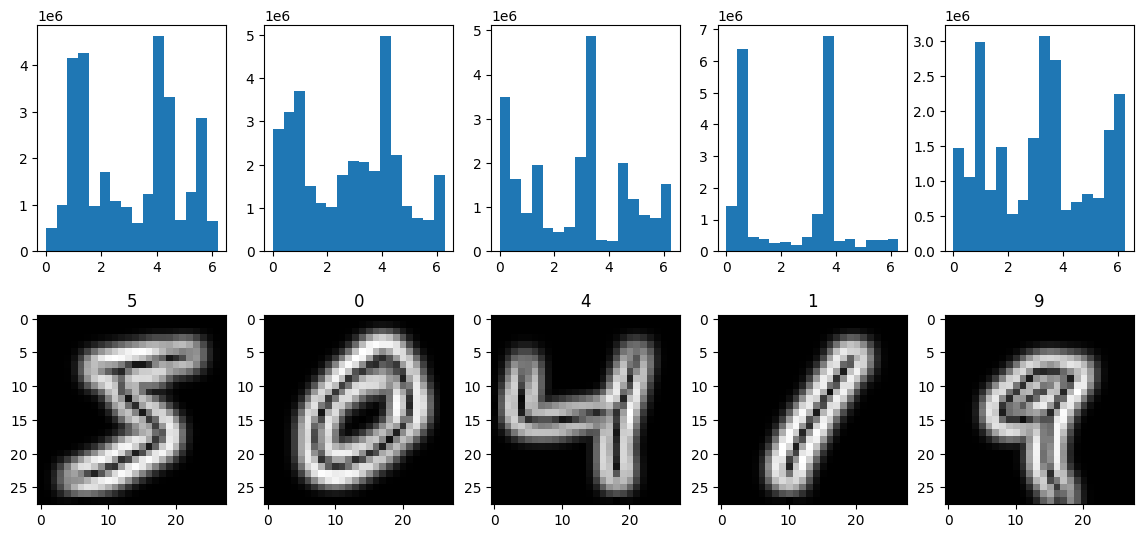

In [51]:
# посмотрим
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_train[i-1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i-1].flatten(),
             bins=16, weights=train_g[i-1].flatten())

## Построим сеточку для распознавания

In [ ]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers as L

In [ ]:
try:
  K.clear_session()
  del model
except:
  pass

# зададим входной слой
input_shape = L.Input(shape=(28,28))

# зададим 1-ю цепочку

# объединим
#merged = L.concatenate([way_1, way_2, way_3, way_4])
merged = L.Flatten()(input_shape)
out = L.BatchNormalization()(merged)

# добавим полносвязные слои
out = L.Dense(256, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(128, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(32, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(10, activation='softmax')(out)

# соберем модель
model = keras.Model(input_shape, out, name='My_model')

In [ ]:
# посмотрим
model.summary()

In [ ]:
# зададим параметры
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['sparse_categorical_accuracy']   # для целочисленных меток
epochs = 32
learning_rate = 0.001
batch_size = 16
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# скомпилируем модель
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# обучим модель
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=None,
          #callbacks=[reduce_lr],
          validation_split=0.2
)

## Вычисляем гистограммы градиентов

In [52]:
# Гистограммы вычисляются с учетом длины вектора градиента
bins = 28
train_hist = np.zeros((len(train_img), bins))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=bins,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [70]:
train_hist.shape

(60000, 28)

In [53]:
bins = 28
test_hist = np.zeros((len(test_img), bins))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=bins,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы


In [55]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [56]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [57]:
# посмотрим размерность
train_hist.shape, test_hist.shape

((60000, 28), (10000, 28))

## Разбиваем выборку на обучение и валидацию

In [71]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(train_hist,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [59]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [60]:
for i in range(10):
    centroids[i] = np.mean(train_x[train_y == i], axis=0)

## Находим ближайший центройд для валидации

In [61]:
pred_val = np.zeros_like(val_y)
for i in range(len(val_y)):
    distances = np.linalg.norm(centroids - val_x[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [62]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(val_y, pred_val))

Accuracy: 0.46841666666666665


In [65]:
from sklearn.metrics import classification_report
print(classification_report(val_y, pred_val))

              precision    recall  f1-score   support

           0       0.28      0.25      0.27      1175
           1       0.67      0.75      0.70      1322
           2       0.46      0.36      0.40      1174
           3       0.51      0.53      0.52      1219
           4       0.41      0.36      0.38      1176
           5       0.51      0.66      0.58      1104
           6       0.33      0.47      0.38      1177
           7       0.58      0.53      0.55      1299
           8       0.41      0.41      0.41      1160
           9       0.52      0.34      0.41      1194

    accuracy                           0.47     12000
   macro avg       0.47      0.47      0.46     12000
weighted avg       0.47      0.47      0.46     12000



In [66]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_y, pred_val))

[[298  15  83  68 145  56 265   9 207  29]
 [  7 985   8   3  19   1  96 182  20   1]
 [ 89   2 421 234  14 281  49  17  55  12]
 [ 69   0 159 651  11 211   9   2  73  34]
 [ 72 190  17  16 423   2 256  74  44  82]
 [ 34   0 121 109   4 726  23   6  80   1]
 [161  33  33  37 160  21 552  28  92  60]
 [ 44 181  11  46  26  36 164 684  34  73]
 [217   7  45  74  65  72 108  11 470  91]
 [ 57  61  18  47 175   4 172 166  83 411]]


## Предсказания на тестовыйх данных

In [67]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

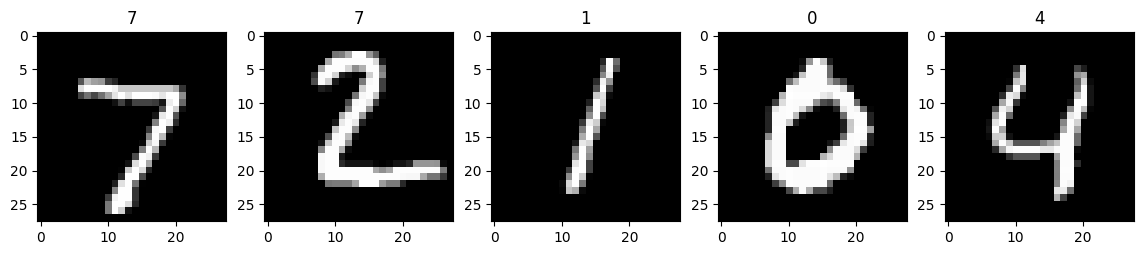

In [68]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Построим сеточку для распознавания

In [73]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers as L

In [79]:
try:
  K.clear_session()
  del model
except:
  pass

# зададим входной слой
input_shape = L.Input(shape=(28,))

# зададим 1-ю цепочку

# объединим
#merged = L.concatenate([way_1, way_2, way_3, way_4])
merged = L.Flatten()(input_shape)
out = L.BatchNormalization()(merged)

# добавим полносвязные слои
out = L.Dense(256, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(128, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(32, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(10, activation='softmax')(out)

# соберем модель
model = keras.Model(input_shape, out, name='My_model')

In [80]:
# посмотрим
model.summary()

Model: "My_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28)                  │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           7,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,554 (181.85 KB)

 Trainable params: 45,666 (178.38 KB)

 Non-trainable params: 888 (3.47 KB)

In [ ]:
# зададим параметры
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['sparse_categorical_accuracy']   # для целочисленных меток
epochs = 32
learning_rate = 0.001
batch_size = 16
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# скомпилируем модель
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# обучим модель
model.fit(train_hist, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=None,
          #callbacks=[reduce_lr],
          validation_split=0.2
)

Epoch 1/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 1.2838 - sparse_categorical_accuracy: 0.5506 - val_loss: 0.8757 - val_sparse_categorical_accuracy: 0.6846
Epoch 2/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.9881 - sparse_categorical_accuracy: 0.6494 - val_loss: 0.7763 - val_sparse_categorical_accuracy: 0.7316
Epoch 3/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.9328 - sparse_categorical_accuracy: 0.6700 - val_loss: 0.7481 - val_sparse_categorical_accuracy: 0.7386
Epoch 4/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.8871 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.7492
Epoch 5/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.8723 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.6987 - val_sparse_categorical_accuracy: 0.7528
Epoch 6/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.8472 - sparse_categorical_accuracy: 0.7019 - val_loss: 0.6719 - val_sparse_categorical_acc

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit.txt

In [ ]:
# Your submission scored 0.41700